# Workflow for processing Lake George field data

In [1]:
import csv, glob, sys, os, re
from os import listdir
import numpy as np
import pandas as pd

#%pylab notebook
import datacube
from datetime import datetime, timedelta
import pyproj
from pandas import Series
import matplotlib.pyplot as plt
import matplotlib
#
# dc will be used later on when comparing with satellite data:
#
#dc = datacube.Datacube(app='nbart-fieldsites')

In [2]:
#
# Set up input and output directories etc.
#
indir = '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/lake_george/26_march_2018/'
output = indir+'OUTPUT/'
field_site = 'Lake George'
panel_dir =  '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/lake_george/26_march_2018/'
in_panel = 'ga_panel1_jan_2018.txt'
suffix = 'asd.rad.txt'

#
# Setup based on Emma's code
#
sat_resp = dict({'lsat5': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat5_vsir.flt', 
            'lsat7': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat7_vsir.flt', 
            'lsat8': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat8_vsir.flt'})

# input file
home2 = '/g/data1a/u46/users/aw3463/GuyByrne/in_spectra/gunning/fr/' 
suffix2 = 'asd.ref.sco.txt'

In [3]:
def spec_readin(suffix, home):
    #
    # Initalise 'spectra' list and fill with files that end in 'suffix'
    #
    spectra = []
    for root, dirs, files in sorted(os.walk(home)):
        for file in files:
            if file.endswith(suffix):
                spectra.append(file)
    spectra = sorted(spectra)
    
    #
    # create list input files - pandas column names
    #
    col_nams = []
    for root, dirs, files in os.walk(home):
        for file in files:
            if file.endswith(suffix):
                tmp = file[:-12] 
                col_nams.append(tmp)
    col_nams = sorted(col_nams)
    
    #
    # Loop over the number of spectra and read in spectral data 
    # into a table 'df'
    #
    count = len(spectra) - 1
    for i in range (0, len(spectra)):
        infile = spectra[i]
        if i == 0:
            df = pd.read_csv(home + infile, skiprows=38, delim_whitespace=True)
        else:
            tmpDF = pd.read_csv(home + infile, skiprows=38, delim_whitespace=True)
            df = df.merge(tmpDF)   

    #
    # Identify and read in time stamps
    #
    dft = []
    for i in range (0, len(spectra)):
        infile = spectra[i]
        with open(home+infile) as f:
            for l in f:
                if re.match('Spectrum saved', l):
                    dt = datetime(int(l[22:26]), int(l[16:18]), int(l[19:21]), int(l[30:32]), int(l[33:35]), int(l[36:38]))
                    dft.append([spectra[i], dt])
    
    return df, dft

#df, dft = spec_readin(suffix, home2)
#np.shape(dft)
#print(duff)

#for i in range(len(duff)):
#    diff = duff[i]-duff[0]
#    print(diff.total_seconds())

In [4]:
def k_factor(panel_dir, in_panel):
    #
    # Read in k-factor from csv file and add 'wavelength' label
    #
    k_f = pd.read_csv(panel_dir + in_panel, skiprows=5, delim_whitespace=True)
    # Set index to wavelength
    k_f.set_index("Wavelength", inplace = True) 
    
    return k_f


In [5]:
def panel_mean(home, name):
    df, dft = spec_readin(suffix, home)
    bad_grounds = ['llg_l300038.asd.rad', 'llg_l300039.asd.rad', 'llg_l300040.asd.rad', 'llg_l300041.asd.rad']

    #
    # Identify those readings that are with the panel, rather than ground 
    # reflectance. This is done by assuing the first wavelength value is 
    # greater than 0.1.
    #
    panels = []
    for column in df.columns[1:]:  # skips the first column
        if (df[column].iloc[1] > 0.1):
            panels.append(column)

    #
    # Identify the time stamps for the panels only (pantime) and for
    # true ground measurements (groundtime). 
    #
    # Also drop specific spectra found in "bad_grounds". These are 
    # spectra that are actually reflectances and should be ignored.
    #
    pantime = []
    groundtime = []
    for i in panels:
        for j in range(len(dft)):
            if dft[j][0] == i+'.txt':
                pantime.append(dft[j])
    for j in range(len(dft)):
            if (dft[j][0][:19] in panels) or (dft[j][0][:19] in bad_grounds):
                continue
            else:
                groundtime.append(dft[j])
                
    #
    # For all panel readings, make an average.
    #
    
    new = df.filter(panels, axis = 1)
    
    xbar = new.mean(axis=1)
    # single column of wavelengths
    waves = df['Wavelength']
    xbar.columns = ['xbar'] 
    result = pd.concat([waves, xbar], axis = 1)
    # Set the df index to wavelenth
    result.set_index("Wavelength", inplace = True) 
        
    #
    # Individual panel measurements
    #
    pans = new.copy()
    pans_result = pd.concat([waves, pans], axis=1)
    pans_result.set_index("Wavelength", inplace=True)

    #
    # Create "all_result", which contains all the non-panel spectra
    #
    tmpall = [ row[0] for row in groundtime ]
    tmpall2 = [ row[:19] for row in tmpall ]
    all_result = df.filter(tmpall2, axis = 1)
    
    return df, pantime, groundtime, result, all_result, pans_result.rename({0: name}, axis=1), panels, waves

#df, pantime, groundtime, result, all_result, pans_result, panels, waves = panel_mean(home2, li)
#print(all_result)

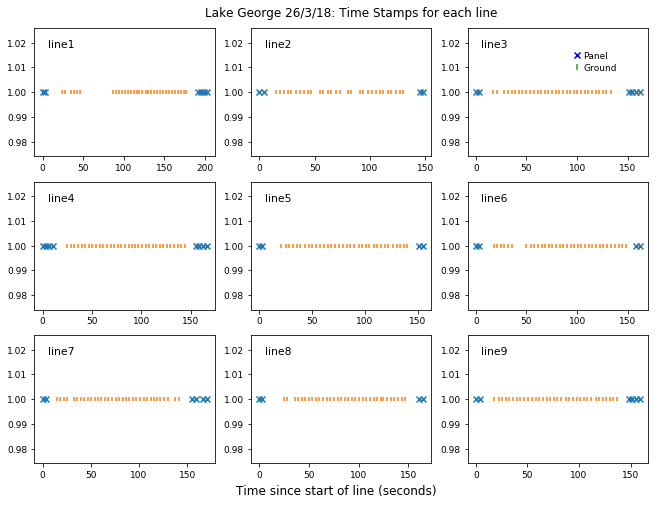

In [6]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})

plt.figure(figsize=(11,8))
plt.figtext(0.38, 0.07, "Time since start of line (seconds)")
plt.figtext(0.34, 0.9, 'Lake George 26/3/18: Time Stamps for each line')

#
# For each line, plot the panel and ground time stamps.
#
for li in range(1, len(glob.glob(indir+'line*'))):
    pan_indiv = []
    pan_time = []
    time_axis = []
    ground_indiv = []
    ground_time = []
    gtime_axis = []

    home2 = indir+'line'+str(li)+'/'
    df, pantime, groundtime, result, all_result, pans_result, panels, waves = panel_mean(home2, li)
    pan_indiv.append(pans_result)
    pan_time.append(pantime)
    
    #
    # Panel data
    #
    pans_indiv = pd.concat(pan_indiv, axis=1)
    pan_times = np.array(sum(pan_time, []))
    median_panel = pans_indiv.median(axis=1)
    normalised_panels = pans_indiv.div(median_panel, axis=0)
    averages = normalised_panels.mean(axis=0)

    for i in range(len(pan_times)):
        diff = pan_times[i,1]-pan_times[0,1]
        time_axis.append(diff.total_seconds())

    avgs = pd.Series.tolist(averages)
    avgones = [1]*len(avgs)

    #
    # Ground data
    #
    ground_indiv.append(all_result)
    ground_time.append(groundtime)
    grounds_indiv = pd.concat(ground_indiv, axis=1)
    ground_times = np.array(sum(ground_time, []))
    median_ground = grounds_indiv.median(axis=1)
    normalised_grounds = grounds_indiv.div(median_ground, axis=0)
    gaverages = normalised_grounds.mean(axis=0)
    # Create a list of ones, with the length of gaverages. This can be plotted
    # so the ground data all appears on a line=1
    gones = [1]*len(gaverages)

    for i in range(len(ground_times)):
        diff = ground_times[i,1]-pan_times[0,1]
        gtime_axis.append(diff.total_seconds())

    gavgs = pd.Series.tolist(gaverages)

    matplotlib.rcParams.update({'font.size': 9})
    plt.subplot(3,3,li)
    plt.scatter(time_axis, avgones, marker='x')
    #plt.plot(time_axis, avgs)
    plt.title('line'+str(li), x=0.15, y=0.8)
    #plt.tight_layout()
    plt.scatter(gtime_axis, gones, marker="|", s=10)
    if li == 3:
        plt.scatter(100, 1.01, marker="|")
        plt.scatter(100, 1.015, marker="x", c='b')
        plt.figtext(0.818, 0.828, "Panel")
        plt.figtext(0.818, 0.806, "Ground")

    
plt.savefig(output+'TimeLineData.png')


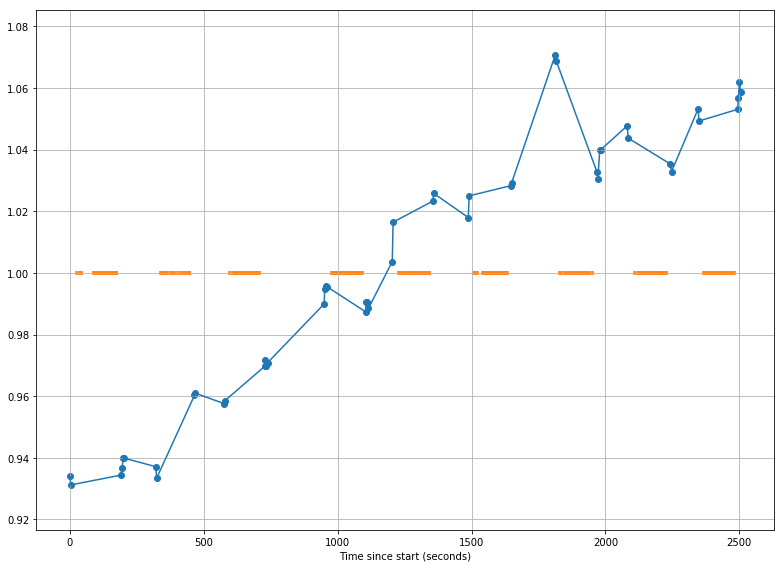

In [7]:
#
# Iterate over each line to determine panel results (pans_result).
# Determine the median Panel spectrum (median_panel), normalise all
# individual panels, using the median (normalised_panels) and determine
# (mean) average (in wavelength) for each normalised panel (averages). 
#
pan_indiv = []
pan_time = []
time_axis = []
ground_indiv = []
ground_time = []
gtime_axis = []

for li in range(1, len(glob.glob(indir+'line*'))):
    home2 = indir+'line'+str(li)+'/'
    df, pantime, groundtime, result, all_result, pans_result, panels, waves = panel_mean(home2, li)
    pan_indiv.append(pans_result)
    pan_time.append(pantime)
    ground_indiv.append(all_result)
    ground_time.append(groundtime)
    
#
# Panel data
#
pans_indiv = pd.concat(pan_indiv, axis=1)
pan_times = np.array(sum(pan_time, []))
median_panel = pans_indiv.median(axis=1)
normalised_panels = pans_indiv.div(median_panel, axis=0)
averages = normalised_panels.mean(axis=0)

for i in range(len(pan_times)):
    diff = pan_times[i,1]-pan_times[0,1]
    time_axis.append(diff.total_seconds())

avgs = pd.Series.tolist(averages)

#
# Ground data
#
grounds_indiv = pd.concat(ground_indiv, axis=1)
ground_times = np.array(sum(ground_time, []))
median_ground = grounds_indiv.median(axis=1)
normalised_grounds = grounds_indiv.div(median_ground, axis=0)
gaverages = normalised_grounds.mean(axis=0)
# Create a list of ones, with the length of gaverages. This can be plotted
# so the ground data all appears on a line=1
gones = [1]*len(gaverages)

for i in range(len(ground_times)):
    diff = ground_times[i,1]-pan_times[0,1]
    gtime_axis.append(diff.total_seconds())

gavgs = pd.Series.tolist(gaverages)

matplotlib.rcParams.update({'font.size': 10})
plt.figure(figsize=(11,8))
plt.scatter(time_axis, avgs)
plt.plot(time_axis, avgs)
plt.xlabel("Time since start (seconds)")
plt.scatter(gtime_axis, gones, marker="|", s=10)
plt.tight_layout()
plt.grid()
plt.savefig(output+'TimeData.png')


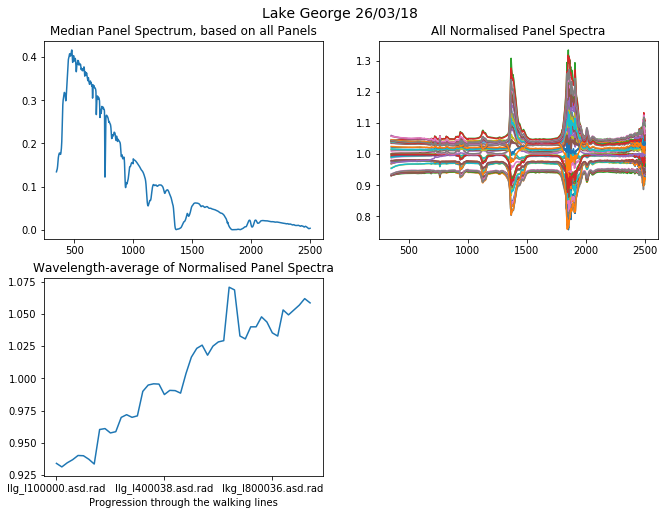

In [8]:

#
# Plot Panel results in three panels. Top-left shows the median panel spectrum.
# Top-right shows the individual normalised spectra. Bottom-left shows the
# average of each normalised spectrum, plotted in order of time along the
# x-axis.
#
matplotlib.rcParams.update({'font.size': 10})
plt.figure(figsize=(11,8))

plt.subplot(2,2,1)
plt.plot(median_panel)
plt.title("Median Panel Spectrum, based on all Panels")

plt.subplot(2,2,2)
plt.plot(normalised_panels)
plt.title("All Normalised Panel Spectra")

plt.subplot(2,2,3)
plt.plot(averages)
plt.title("Wavelength-average of Normalised Panel Spectra")
plt.xticks([0, 20, 40])
plt.xlabel("Progression through the walking lines")
matplotlib.rcParams.update({'font.size': 14})
plt.figtext(0.4, 0.92, "Lake George 26/03/18")

#plt.tight_layout()
plt.savefig(output+'Wave-avg-Norm-Panel-Spec.png')

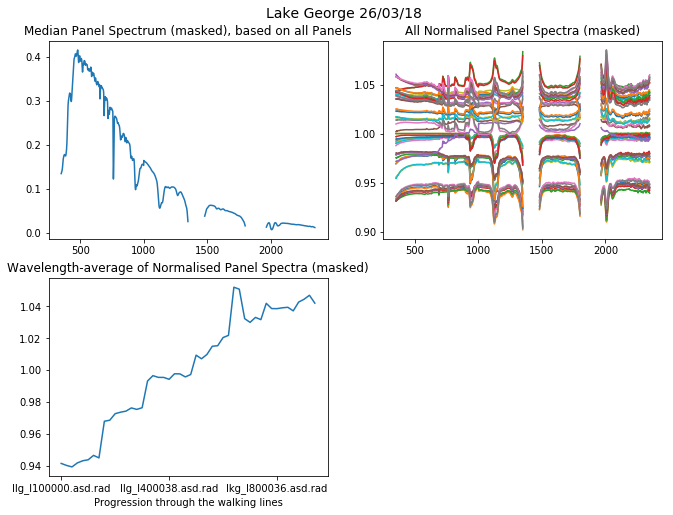

In [9]:
#
# Create a mask to avoid wavelengths where atmospheric transmission is
# close to zero: 1350-1480nm, 1801-1966nm and >2350nm
#
mask1 = median_panel.where(np.logical_or(median_panel.index<1350, median_panel.index>1480))
mask2 = mask1.where(np.logical_or(mask1.index<1801, mask1.index>1966))
median_panel_masked = mask2.where(np.logical_or(mask2.index<2350, mask2.index>2500))

#
# The follwing line will creat an extreme mask, including only wavelengths
# between 1600 and 1700nm.
#
#median_panel_masked = median_panel.where(np.logical_and(mask2.index<1700, mask2.index>1600))

normalised_panels_masked = pans_indiv.div(median_panel_masked, axis=0)
averages_masked = normalised_panels_masked.mean(axis=0)


#
# Plot Panel results in three panels. Top-left shows the median panel spectrum.
# Top-right shows the individual normalised spectra. Bottom-left shows the
# average of each normalised spectrum, plotted in order of time along the
# x-axis.
#
matplotlib.rcParams.update({'font.size': 10})
plt.figure(figsize=(11,8))

plt.subplot(2,2,1)
plt.plot(median_panel_masked)
plt.title("Median Panel Spectrum (masked), based on all Panels")

plt.subplot(2,2,2)
plt.plot(normalised_panels_masked)
plt.title("All Normalised Panel Spectra (masked)")

plt.subplot(2,2,3)
plt.plot(averages_masked)
plt.title("Wavelength-average of Normalised Panel Spectra (masked)")
plt.xticks([0, 20, 40])
plt.xlabel("Progression through the walking lines")
matplotlib.rcParams.update({'font.size': 14})
plt.figtext(0.4, 0.92, "Lake George 26/03/18")

#plt.tight_layout()
plt.savefig(output+'Wave-avg-Norm-Panel-Spec-Masked.png')

In [10]:
def create_reflectances(home, name):
    #
    # Create reflectances 
    #
    df, pantime, groundtime, result, all_result, pans_result, panels, waves = panel_mean(home, li)
    k_f = k_factor(panel_dir, in_panel)
    # Copy the dataframe 
    temp = df 
    
    #
    # Delete the refl panel columns and 'Wavelength' column
    #
    radwave = temp.drop(panels, axis = 1) 
    radiances = radwave.drop(labels='Wavelength', axis=1)

    #
    # Calculate mean of radiances
    #
    xbar_rads = radiances.mean(axis=1)
    # Add wavelength 
    xbar_radiances = pd.concat([waves, xbar_rads], axis = 1)  
    # Set the df index to wavelenth
    xbar_radiances.set_index("Wavelength", inplace = True) 
    #Divide radiances by average of panels to normalise
    refl_tmp = xbar_radiances.div(result)  
    #Multiply by k-factor
    line_refls = refl_tmp * k_f.values

    return line_refls.rename({0: name}, axis=1), df, panels, waves

#line_refls, df, panels, waves = create_reflectances(home2, li)

<IPython.core.display.Javascript object>


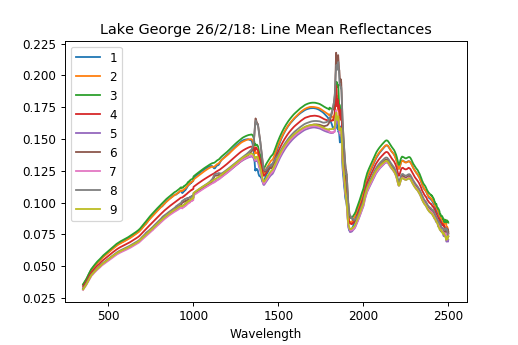

In [22]:
for li in range(1, len(glob.glob(indir+'line*'))):
    home2 = indir+'line'+str(li)+'/'
    temp, df, panels, waves = create_reflectances(home2, li)
        
    if li == 1:
        refls = temp
    else:
        tmp_refls = temp
        refls = pd.concat([refls, tmp_refls], axis=1)   
#print(refls)

%matplotlib notebook

jstest = refls.copy()

# set index is replacing the pandas data frame native index with the spectum wl
#jstest.set_index('Wavelength', inplace=True)


jstest[1:2500].plot(title = "Lake George 26/2/18: Line Mean Reflectances")
plt.savefig(output+'LineMeanReflectances.png')

In [18]:
def get_spectrum_curve(f_name):
    band_n = dict() 
    key = list()
    wavelength = np.array([], dtype='float64') 
    response = np.array([], dtype='float64') 
    with open(f_name, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=' ', skipinitialspace=True)
        for row in csv_reader:
            if row[0].lower().find('band') >= 0:
                key.append(row[0].lower()+row[1])
                if wavelength.shape[0] > 0:
                    spectrum_curve = np.vstack([wavelength, response]).T
                    band_n.update({key[len(key)-2]: spectrum_curve})
                    wavelength = np.array([], dtype='float64') 
                    response = np.array([], dtype='float64') 
            else:
                wavelength = np.append(wavelength, float(row[0]))
                response = np.append(response, float(row[1]))
    spectrum_curve = np.vstack([wavelength, response]).T
    band_n.update({key[len(key)-1]: spectrum_curve})
    wavelength = np.array([], dtype='float64') 
    response = np.array([], dtype='float64') 
    return band_n 

In [19]:
def field_int_curve(field_data, band):
    result = np.zeros(len(band))
    i = 0
    for b in band:
        spectrum_curve = band[b]
        dom_a = max(min(spectrum_curve[:, 0]), min(field_data[:, 0]))
        dom_b = min(max(spectrum_curve[:, 0]), max(field_data[:, 0]))
        source_x = field_data[:, 1][np.where((field_data[:, 0] >= dom_a) & 
                (field_data[:, 0] <= dom_b))]
        source_y = spectrum_curve[:, 1][np.where((spectrum_curve[:, 0] >= dom_a) & 
            (spectrum_curve[:, 0] <= dom_b))]
        result[i] = sum(source_x*source_y)/sum(source_y)
        i += 1
    return result

In [20]:
f_name = sat_resp['lsat8']
band = get_spectrum_curve(f_name)
result = []
field_data = grounds_indiv
wave_length = np.array(df['Wavelength'], dtype='float64')
for col in field_data.columns:
    source_x = np.vstack([wave_length, np.array(field_data[col], dtype='float64')]).T
    result.append(field_int_curve(source_x, band))
result_df = pd.DataFrame(result)
result_df.columns = list(band.keys())

<IPython.core.display.Javascript object>


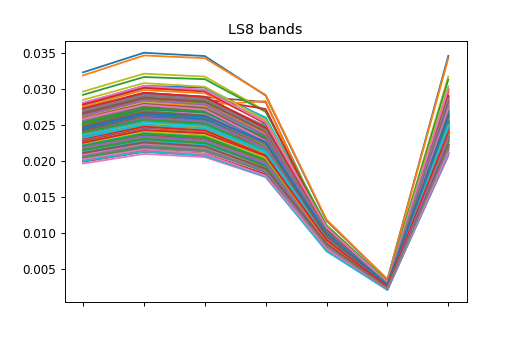

In [23]:
%matplotlib notebook
result_df
index = result_df.index
start = 0
stop = 100
result_df.iloc[start:stop]
result_df.columns
new_df = result_df.transpose()
new_df

new_df[1:2500].plot(title = "LS8 bands", legend=False)

In [16]:
# def test_example():
f_name = sat_resp['lsat8'] 
band = get_spectrum_curve(f_name)
field_data = retrieve_data_from_file(home2)
wave_length = np.array(field_data['Wavelength'], dtype='float64')
result = []
for col in field_data.columns[1:]:
    source_x = np.vstack([wave_length, np.array(field_data[col], dtype='float64')]).T
    result.append(field_int_curve(source_x, band))
result_df = pd.DataFrame(result)
result_df.columns = list(band.keys())
#return result_df

NameError: name 'retrieve_data_from_file' is not defined

In [ ]:
#            
# Loop over the number of available 'line' files in directory 'indir'
# with .asd.rad.txt extension.
#

dataframes = []

for li in range(1, len(glob.glob(indir+'line*'))):
    home2 = indir+'line'+str(li)+'/'
    temp, df, panels, waves = create_reflectances(home2, li)
    
    dataframes.append(temp)

jstest = pd.concat(dataframes, axis=1)
#print(jstest, df)
#mean_panel = ind_jstest.mean(axis=1)
#divr = mean_panel.div(median_panel, axis=0)
#norm_med = ind_jstest.div(median_panel, axis=0)

In [ ]:
%matplotlib notebook
mvs2 = jstest.iloc[102:163]
mvs3 = jstest.iloc[183:241]
mvs4 = jstest.iloc[286:324]
mvs5 = jstest.iloc[502:530]
mvs6 = jstest.iloc[1216:1302]
mvs7 = jstest.iloc[1757:1945]

jstest[1:2500].plot(title = "Reflectances for each line", xlim=(350,2500), legend=False)
ax = mvs2[1:2500].plot(title = "Reflectance response for each LS8 band", xlim=(350,2500), legend=False)
mvs3[1:2500].plot(ax=ax, legend=False)
mvs4[1:2500].plot(ax=ax, legend=False)
mvs5[1:2500].plot(ax=ax, legend=False)
mvs6[1:2500].plot(ax=ax, legend=False)
mvs7[1:2500].plot(ax=ax, legend=False)